# Decompose the Bering Strait velocity terms into the geostrophic, barotropic, and residual

In [1]:
import subprocess
import xarray as xr
import numpy as np
from glob import glob
from xgcm import Grid

## Load and preprocess data

In [2]:
def open_model_data(flist):
    # dmget files
    _ = subprocess.run(["dmget"]+ flist, check=True)
    
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',
                           engine='netcdf4',drop_variables=v2drop)
    
    return DS

def preproc_data(path,time_chunk):
    # file list
    flist = (
        glob(f'{path}ocean_Bering_Strait.{time_chunk}.so.nc') +
        glob(f'{path}ocean_Bering_Strait.{time_chunk}.thetao.nc') +
        glob(f'{path}ocean_Bering_Strait.{time_chunk}.vo.nc') +
        glob(f'{path}ocean_Bering_Strait.{time_chunk}.volcello.nc')
    )
    
    # open the data and clean up
    DS = open_model_data(flist)
    
    # dmget os
    f_os = path + '../../../ocean_Bering_Strait.static.nc'
    _ = subprocess.run(["dmget"]+[f_os],check=True)
    
    # open the static file
    OS = xr.open_dataset(f_os,engine='netcdf4'
                        )
    # rename coords to match pp'ed data
    for coord in list(OS.coords):
        OS = OS.rename_dims({coord:(coord + '_sub01')}
                           ).rename({coord:(coord + '_sub01')})
    
    # subset for Bering Strait
    # THIS CODE USUALLY WORKS BUT SUDDENLY ISNT
    # THIS IS CONCERNING BUT UNCLEAR WHAT IS HAPPENING...
    # OS = OS.sel(xq_sub01=slice(DS.xh_sub01[0],
    #                            DS.xh_sub01[-1]-(DS.xh_sub01[-2]-DS.xh_sub01[-1]))
    #            ).sel(xh_sub01=DS.xh_sub01,yq_sub01=DS.yq_sub01,yh_sub01=DS.yh_sub01)
    # HARD CODING BECAUSE I NEED TO GET THIS DONE (UGH)
    OS = OS.isel(yh_sub01=858,yq_sub01=858,
                 xh_sub01=slice(517,528),xq_sub01=slice(517,528))
    
    # merge OS into DS
    DS = xr.merge([DS, OS])
    
    return DS

## Calc $v_{geo}$ and $v_{barotropic}$

In [3]:
def pdens(S,theta,local=True):
    """Calculate potential density [in kg m-3] referenced to the surface according to the 
    expressions from Wright 1997, J. Atmos. Ocean. Tech., 14, 735 - 740.
    
    This is the computation for potential density used within MOM6
    
    Parameters
    ----------
    salt : xarray.DataArray
        Data Array containing salinity in psu
    theta: xarray.DataArray
        Data Array containing potential temperature relative to the sea surface in degree C
        
    Returns
    ----------
    xarray.DataArray
        Data Array containing potential density in kg m-3"""

    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa (100000 Pa) 
    # --- approx. sea level pressure.
    # S in standard salinity units psu, theta in DegC, p in pascals

    if local == True:
        ### Depth is in m, for Boussinesque depth == pressure in dbar, 
        ### dbar to Pa is dbar*10,000, add sea level [pressure to this]
        p = S.z_l*10000  + 100000  
    else: p = 100000.              ### Sea level pressure

    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S

    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))

    return pot_dens

def decomp_v(DS):
    # Subset DS for calc
    DS4v = DS.isel(xh_sub01=slice(1,-1),xq_sub01=slice(1,-1))
    
    # make grid for Bering Strait section
    grid = Grid(DS4v,
                coords={'X': {'center': 'xh_sub01', 'right': 'xq_sub01'},
                        'Y': {'center': 'yh_sub01', 'right': 'yq_sub01'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} },
                periodic=['Y'])
    # Gravity
    g = 9.81
    # Reference density [m2/s]
    rho0 = 1035.
    
    # calculate density
    DS4v['rho'] = pdens(DS4v.so,DS4v.thetao)
    # interpolate to u points
    DS4v['rho_u'] = grid.interp(DS4v.rho,'X',boundary='extend').chunk(chunks=-1)
    # interpolate to f points
    DS4v['rho_f'] = grid.interp(DS4v.rho_u,'Y')
    
    # calculate density gradients
    drho_dx = grid.diff(DS4v.rho_f,'X',boundary='extend') * DS4v.dxCv / DS4v.areacello_cv
    
    # interpolate f onto v points
    f = grid.interp(DS4v.Coriolis,'X',boundary='extend'
                   ).expand_dims(dim={"time": DS4v.time,"z_l": DS4v.z_l})
    
    # calc cell thickness
    DS4v['dz'] = grid.interp(DS4v.volcello / DS4v.areacello,'Y')
    # calc geostrophic shear
    dvg = -(g/f) * drho_dx * DS4v.dz / rho0
    
    # intergrate from bottom up
    DS4v['vo_g'] = dvg.reindex(
        z_l=dvg.z_l[::-1]).cumsum('z_l').reindex(z_l=dvg.z_l).chunk(
        chunks=-1).where(DS4v['vo'].notnull(),np.nan)
    
    # calc barotropic velocity
    DS4v['vo_bt'] = DS4v.vo.isel(z_l=(DS4v.vo.isel(time=0).notnull() * DS4v.z_l).argmax(
        dim='z_l').drop('time').compute()).drop('z_l').expand_dims(
        dim={"z_l": DS4v.z_l}).where(DS4v['vo'].notnull(),np.nan)
    
    # insert caclulate vo's back into original array dimensions
    DS = xr.merge([DS, 
                   DS4v['vo_bt'].transpose('time', 'z_l', 'yq_sub01', 'xh_sub01'), 
                   DS4v['vo_g'].transpose('time', 'z_l', 'yq_sub01', 'xh_sub01')])
    
    return DS

## Calc geostrophic and barotropic velocities for each experiment and add to pp

In [4]:
base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/'
pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_Bering_Strait/ts/daily/*yr/'
exps = glob(f'{base}OM4p25_JRA55do1.4_0netfw_cde.02_*')

In [6]:
# work through each experiment
for exp in exps:
    print(f'Working on {exp}')
    # get list of chunks to prepocess
    vo_files = glob(f'{exp}{pp}*.vo.nc')
    # work through each time chunk
    for vo_file in vo_files:
        # get time chunk
        time_chunk = vo_file.split('.')[-3]
        # get path
        path = "/".join(vo_file.split("/")[:-1]) + '/'
        # preproc experiment data
        DS = preproc_data(path,time_chunk)
        # decompose vel
        DS = decomp_v(DS)
        # save netcdfs
        print(f'Saving time chunk {time_chunk}...')
        DS['vo_bt'].to_netcdf(f'{path}ocean_Bering_Strait.{time_chunk}.vo_bt.nc')
        DS['vo_g'].to_netcdf(f'{path}ocean_Bering_Strait.{time_chunk}.vo_g.nc')

Working on /archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_ctrl
Saving time chunk 19980101-20021231...
Saving time chunk 20030101-20071231...
Saving time chunk 20080101-20121231...
Saving time chunk 20130101-20171231...
Working on /archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_68.193_Lx300_Ly500_tau28_v20
Saving time chunk 20080101-20081231...
Working on /archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_68.193_Lx300_Ly500_tau28_v0
Saving time chunk 20080101-20081231...
Working on /archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_68.193_Lx300_Ly500_tau28_v1
Saving time chunk 20080101-20081231...
Working on /archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_68.193_Lx300_Ly500_tau28_v2.5
Saving time chunk 20080101-20081231...
Working on /archive/Marion.Alberty/FMS2021.02_mo

## test plots

In [5]:
exp = exps[0]
vo_files = glob(f'{exp}{pp}*.vo.nc')
vo_file = vo_files[0]
# get time chunk
time_chunk = vo_file.split('.')[-3]
# get path
path = "/".join(vo_file.split("/")[:-1]) + '/'

In [6]:
# file list
flist = (
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.so.nc') +
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.thetao.nc') +
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.vo.nc') +
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.vo_g.nc') +
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.vo_bt.nc') +
    glob(f'{path}ocean_Bering_Strait.{time_chunk}.volcello.nc')
)

In [7]:
# open the data and clean up
DS = open_model_data(flist)

In [8]:
import cmocean
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [9]:
vmm = 0.25

/nbhome/Marion.Alberty/miniconda/envs/phys_ocean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


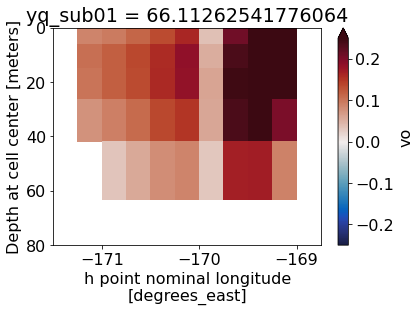

In [10]:
DS.vo.mean('time').plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

/nbhome/Marion.Alberty/miniconda/envs/phys_ocean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


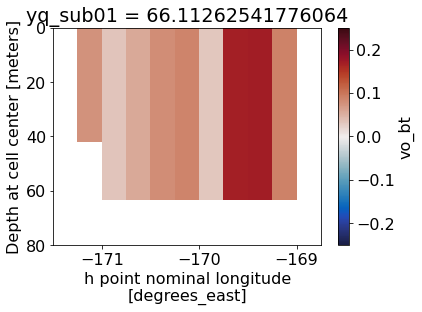

In [11]:
DS.vo_bt.mean('time').plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

/nbhome/Marion.Alberty/miniconda/envs/phys_ocean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


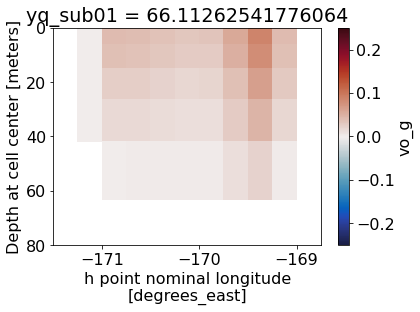

In [12]:
DS.vo_g.mean('time').plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

/nbhome/Marion.Alberty/miniconda/envs/phys_ocean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


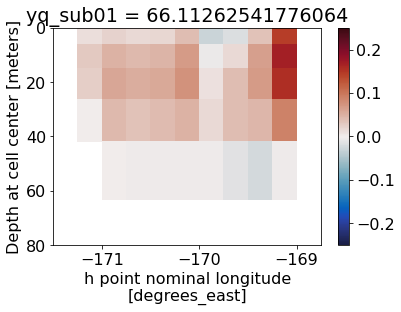

In [13]:
(DS.vo.mean('time') - DS.vo_bt.mean('time') - DS.vo_g.mean('time')).plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()